# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [64]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [65]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [66]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [67]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [68]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [69]:

def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [70]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

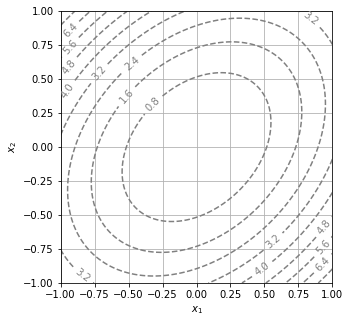

In [71]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [72]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

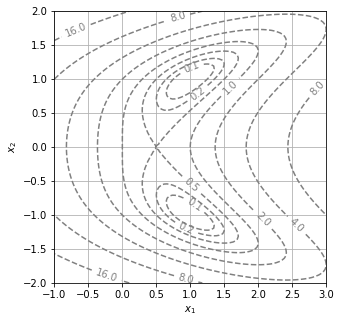

In [73]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [74]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

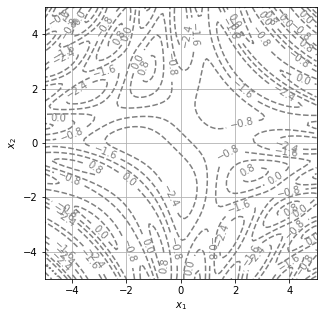

In [75]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [76]:
N = 100
eps = 0.01 
#Si epsilon est trop petit, le nombre d'itérations de la fonction Newton sera très grand ce qui augmente le temps de calcul
#Si epsilon est trop grand, la précison du résultat sera mauvaise
#Ainsi, il faut trouver un compromis. Nos essais montre que eps = 0.01 convient.




**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

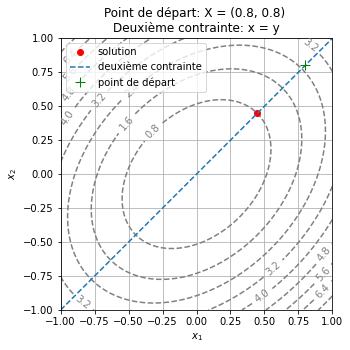

In [77]:
def F1(x, y):
    """
    Le -0.8 permet à la fonction Newton de chercher une solution sur la ligne de niveau 0.8
    La deuxième coordonée permet de prendre en compte la condition x=y
    """
    x = np.array(x)
    y = np.array(y)
    return np.array([3.0 * x * x - 2.0 * x * y + 3.0 * y * y - 0.8, y-x])  


def Newton(F, x0, y0, eps=eps, N=N):
    x=x0
    y=y0
    for i in range(N):
        A=J(F)(x0,y0)
        (x,y)= - np.linalg.solve(A,F(x0,y0)) + (x,y)   #On résout un système d'équation
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")
      
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, # 5 levels, automatically selected
)


X = Newton(F1, 0.8, 0.8)
Y = np.linspace(-1.0, 1.0, 100)

plt.plot(X[0], X[1], 'ro', label = 'solution');
plt.plot(Y, Y, '--', label = 'deuxième contrainte');   #On trace la 1ère bissectrice
plt.plot(0.8, 0.8, 'g+', markersize = 10, label = 'point de départ');
plt.title('Point de départ: X = (0.8, 0.8) \nDeuxième contrainte: x = y');
plt.legend();

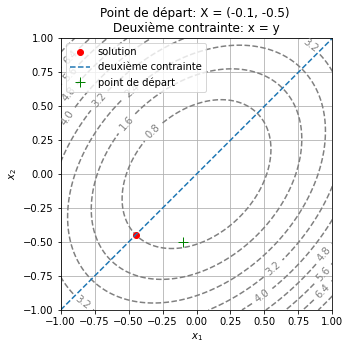

In [78]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, # 5 levels, automatically selected
)


X = Newton(F1, -0.1, -0.5)
Y = np.linspace(-1.0, 1.0, 100)

plt.plot(X[0], X[1], 'ro', label = 'solution');
plt.plot(Y, Y, '--', label = 'deuxième contrainte');   #On trace la 1ère bissectrice
plt.plot(-0.1, -0.5, 'g+', markersize = 10, label = 'point de départ');
plt.title('Point de départ: X = (-0.1, -0.5) \nDeuxième contrainte: x = y');
plt.legend();

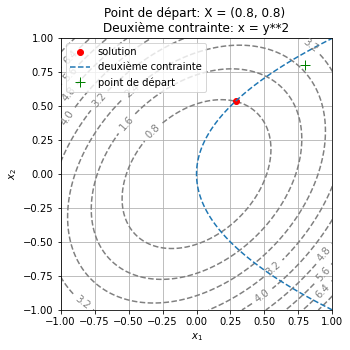

In [79]:
def F1_autre_contrainte(x, y):
    """
    Le -0.8 permet à la fonction Newton de chercher une solution sur la ligne de niveau 0.8
    La deuxième coordonée permet de prendre en compte la condition x=y
    """
    x = np.array(x)
    y = np.array(y)
    return np.array([3.0 * x * x - 2.0 * x * y + 3.0 * y * y - 0.8, y**2-x])  


display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, # 5 levels, automatically selected
)


X = Newton(F1_autre_contrainte, 0.8, 0.8)
Y = np.linspace(-1.0, 1.0, 100)

plt.plot(X[0], X[1], 'ro', label = 'solution');
plt.plot(Y**2, Y, '--', label = 'deuxième contrainte');   #On trace la 1ère bissectrice
plt.plot(0.8, 0.8, 'g+', markersize = 10, label = 'point de départ');
plt.title('Point de départ: X = (0.8, 0.8) \nDeuxième contrainte: x = y**2');
plt.legend();

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [80]:
def Fbis(f,x,y,c,x0,y0,delta):
    return np.array([f(x,y)-c,(x-x0)**2+(y-y0)**2-delta**2]) ### permet de garantir la condition: distance(X,X0)==delta

def Newtonbis(f,x0,y0,delta,s,t,c,eps=eps,N=100): ### Cela n'était pas forcément necessaire, il aurait été possible de se contenter de la fonction level_curve
    X = np.array([x0,y0])
    def J_f(g,h):
        return Fbis(f,g,h,c,s,t,delta)
    j = J(J_f)
    for i in range(N):
        X = X-np.dot(np.linalg.inv(j(x0,y0)),J_f(x0,y0))
        x, y = X[0], X[1]
        if np.sqrt((X[0] - x0)**2 + (X[1] - y0)**2) <= eps:
            return np.array([X[0], X[1]])
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

def level_curve(f, x0, y0, delta=0.01, N=100, eps=eps):
    c=f(x0,y0)
    Result = [[x0],[y0]]
    for k in range(1,N):
        grad_f0 = grad(f)(x0,y0)
        perp = np.cross(np.array([grad_f0[0],grad_f0[1],0]),np.array([0,0,1]))
        Norme = np.linalg.norm(perp)
        x , y = x0 + perp[0]/Norme*delta, y0 + perp[1]/Norme*delta ### décalage d'un vecteur de norme delta vers la droite
        L = Newtonbis(f,x,y,delta,x0,y0,c)
        x0 , y0 = L[0] , L[1]
        Result[0].append(L[0])
        Result[1].append(L[1])
    return np.array(Result) ### Resultat sous forme d'une liste de 2 listes de longueur N



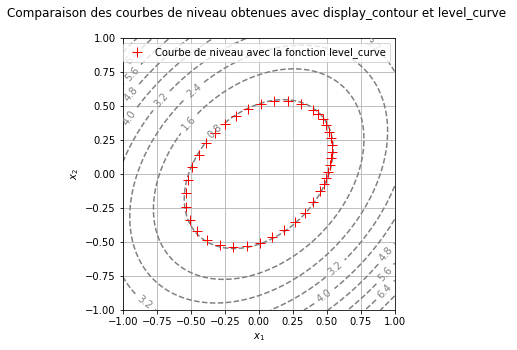

In [81]:
X = level_curve(f1, 0.44, 0.44, 0.1, 40) #Le point de départ est une valeur approchée donnée par la fonction Newton précédente

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, # 5 levels, automatically selected
)
plt.plot(X[0], X[1], 'r+', markersize = 10, label = 'Courbe de niveau avec la fonction level_curve');
plt.legend();
plt.title('Comparaison des courbes de niveau obtenues avec display_contour et level_curve \n');

#On remarque que la fonction effectue plus d'un tour de la courbe

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

In [82]:
#on crée une fonction intersect  qui arrête l'algorithme et renvoie les points connus quand le segment formé 
# par les deux derniers points produits intersecte l'un des segments produits auparavant

def Intersect(P1,P2,P3,P4):
    if (max(P1[0],P2[0]) < min(P3[0],P4[0])): # Pas d'intersection possible car intervalles disjoints.
        return False

    if P1[0]-P2[0] != 0 and P3[0]-P4[0] !=0 :
        A1 = (P1[1]-P2[1])/(P1[0]-P2[0])  # y = ax+b
        A2 = (P3[1]-P4[1])/(P3[0]-P4[0])
        b1 = P1[1]-A1*P1[0]
        b2 = P3[1]-A2*P3[0]
        if A1==A2 : # Segments parrallèles
            return(False)
        else :
            Xa = (b2 - b1) / (A1 - A2) ## abscisse de l'intersection
            if ( (Xa < max(min(P1[0],P2[0]), min(P3[0],P4[0]) )) or (Xa > min( max(P1[0],P2[0]), max(P3[0],P4[0]) )) ):
                return False #L'abscisse de l'intersection doit être dans le domaine de définition des segments
            else :
                return True
    else : #pas utile avec approx flottant
        if (P1[0]-P2[0]==0 and P3[0]-P4[0]==0):
            return False
        else :
            if P1[0]-P2[0]==0 : # on a x = c
                X = P1[0]
                Y =  (P3[1]-P4[1])/(P3[0]-P4[0])*P1[0] + P3[1]-A2*P3[0]
            else :
                X = P3[0]
                Y = (P1[1]-P2[1])/(P1[0]-P2[0])*P3[0]+ P1[1]-A1*P1[0]
            if (min(P1[0],P2[0])<= X<= max(P1[0],P2[0]) and min(P3[0],P4[0])<= X<= max(P3[0],P4[0])) and (min(P1[1],P2[1])<= Y<= max(P1[0],P2[0]) and min(P3[1],P4[1])<= Y<= max(P3[1],P4[1])):
                return True
            else :
                return False

def level_curve_corrige(f, x0, y0, delta=0.1, N=100, eps=eps):
    c = f(x0,y0)
    Result = [[x0],[y0]]
    for k in range(N):
        grad_f0 = grad(f)(x0,y0)
        perp = np.cross(np.array([grad_f0[0],grad_f0[1],0]),np.array([0,0,1]))
        Norme = np.linalg.norm(perp)
        x , y = x0 + perp[0]/Norme*delta, y0 + perp[1]/Norme*delta ### prochain point de départ
        L = Newtonbis(f,x,y,delta,x0,y0,c)
        x0 , y0 = L[0] , L[1]
        Result[0].append(L[0])
        Result[1].append(L[1])
        if k>=1 and Intersect([Result[0][0],Result[1][0]],[Result[0][1],Result[1][1]],[Result[0][-1],Result[1][-1]],[Result[0][-2],Result[1][-2]]):
            return(np.array(Result))  ### on compare juste avec le premier point
    return(np.array(Result))
    
    

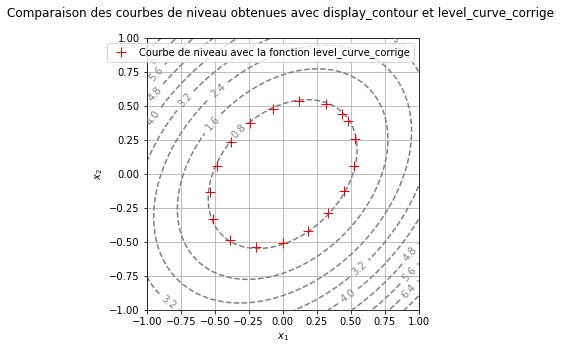

In [83]:
X = level_curve_corrige(f1, 0.44, 0.44, 0.2, 60) #Le point de départ est une valeur approchée donnée par la fonction Newton précédente

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, # 5 levels, automatically selected
)
plt.plot(X[0], X[1], 'r+', markersize = 10, label = 'Courbe de niveau avec la fonction level_curve_corrige');
plt.legend();
plt.title('Comparaison des courbes de niveau obtenues avec display_contour et level_curve_corrige \n');

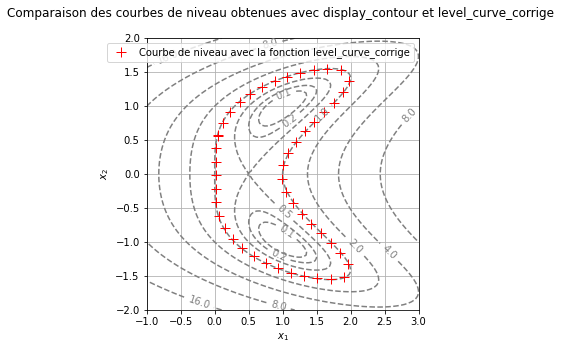

In [84]:

X = level_curve_corrige(f2, 0.05, 0.56, 0.2, 600) #Le point de départ est une valeur approchée donnée par la fonction Newton précédente

display_contour(
    f2, 
    x=np.linspace(-1., 3., 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[ 2**i for i in range(-3,8) ]
)


plt.plot(X[0], X[1], 'r+', markersize = 10, label = 'Courbe de niveau avec la fonction level_curve_corrige');
plt.legend();
plt.title('Comparaison des courbes de niveau obtenues avec display_contour et level_curve_corrige \n');


# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [85]:
def area_square(f, c, h):
    def F(x, y):
        return np.array([f(x,y) - c, x-y])
    x0, y0 = Newton(F, 1., 1.) #Il faut trouver un point de départ pour la fonction level_curve_corrige.
    #Cette méthode est à adapter selon les cas
    X = level_curve_corrige(f, x0, y0)
    x_min, x_max, y_min, y_max = min(X[0]), max(X[0]), min(X[1]), max(X[1])
    subdiv_x = np.arange(x_min, x_max, h)
    subdiv_y = np.arange(y_min, y_max, h)
    cpt = 0 #un compteur
    for x in subdiv_x:
        for y in subdiv_y:
            if f(x, y) < c:
                cpt += 1
    return cpt*h*h




def area_square_avec_graphe(f, c, h):
    def F(x, y):
        return np.array([f(x,y) - c, x-y])
    x0, y0 = Newton(F, 1., 1.) #Il faut trouver un point de départ pour la fonction level_curve_corrige.
    #Cette méthode est à adapter selon les cas
    X = level_curve_corrige(f, x0, y0)
    x_min, x_max, y_min, y_max = min(X[0]), max(X[0]), min(X[1]), max(X[1])
    subdiv_x = np.arange(x_min, x_max, h)
    subdiv_y = np.arange(y_min, y_max, h)
    cpt = 0 #un compteur
    display_contour(
    f, 
    x=np.linspace(-1.5, 1.5, 100), 
    y=np.linspace(-1.5, 1.5, 100), 
    levels= [c], # 5 levels, automatically selected
)
    plt.title(f"centre des carrés inclu dans l'aire A pour {c=} \n")
    for x in subdiv_x:
        for y in subdiv_y:
            if f(x, y) < c:
                cpt += 1
                plt.plot(x, y,'r+')
    return cpt*h*h




Pour c = 1, on obtient une valeur approchée de pi: area_square_avec_graphe(f_cercle, 1, 0.1)=3.1100000000000003


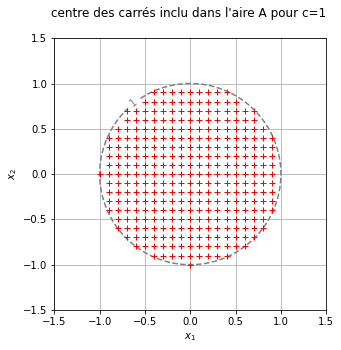

In [86]:
def f_cercle(x, y):
    return np.sqrt(x**2 + y**2)

print(f"Pour c = 1, on obtient une valeur approchée de pi: {area_square_avec_graphe(f_cercle, 1, 0.1)=}")

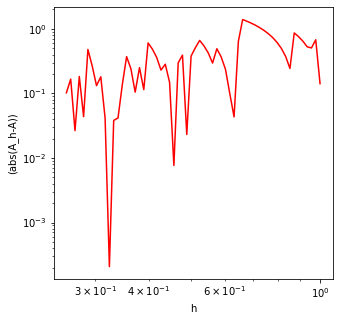

In [87]:
def erreur(f, c, h):
    return (abs(area_square(f, c, h) - np.pi*c**2))

H = [10**k for k in [-i*10**(-2) for i in range(60)]]

plt.plot(H, [erreur(f_cercle, 1, h) for h in H], 'r');
plt.xscale("log");
plt.yscale("log");
plt.xlabel("h");
plt.ylabel("(abs(A_h-A))");


**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [88]:
def encadrement(f, c, h):
    """Retourn les deux bornes de l'encadrement et l'erreur"""
    #on reprend le début de la fonction area_square
    def F(x, y):
        return np.array([f(x,y) - c, x-y])
    x0, y0 = Newton(F, 1., 1.) #Il faut trouver un point de départ pour la fonction level_curve_corrige.
    #Cette méthode est à adapter selon les cas
    X = level_curve_corrige(f, x0, y0)
    x_min, x_max, y_min, y_max = min(X[0]), max(X[0]), min(X[1]), max(X[1])
    subdiv_x = np.arange(x_min, x_max, h)
    subdiv_y = np.arange(y_min, y_max, h)
    cpt_min = 0
    cpt_max = 0 #On a besoin de deux compteurs pour faire l'encadrement
    #Désormais, nous allons regarder si les sommets des carrés sont dans K.
    for x in subdiv_x:
        for y in subdiv_y:
            if f(x,y) < c or f(x+h, y) < c or f(x+h, y) < c or f(x+h, y+h) < c: #Un des sommets est dans K
                cpt_max += 1
            if f(x,y) < c and f(x+h, y) < c and f(x+h, y) < c and f(x, y+h) < c: #Le carré est complètement dans K
                cpt_min += 1
            
    return cpt_min*h*h, cpt_max*h*h, (cpt_max-cpt_min)*h*h

#D'après le graphe précédent, on peut choisir un h assez petit pour que l'intervalle de l'encadrement soit plus petit
#que 10**(-2)

#Après quelques essais, on choisi h = 0.01

m, M, e = encadrement(f_cercle, 1, 0.01)
print(f"{m} < A_h < {M}, on sait que A_h se trouve dans un intervalle de longueur {e} de l'ordre de 10**(-2)")

3.1068000000000002 < A_h < 3.1738, on sait que A_h se trouve dans un intervalle de longueur 0.067 de l'ordre de 10**(-2)


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

L'aire du disque unité est 3.1363213716227434 (avec delta=0.1) 



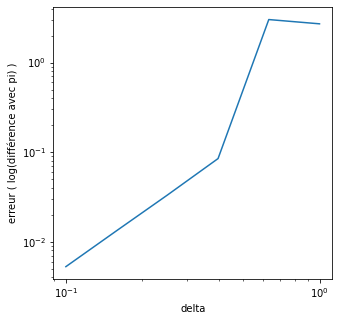

In [89]:
#on cherhe a faire le produit vectoriel entre vect(zi) et vect(zi+1),
#on obtient l'aire du paralélogramme puis on divise par 2.

def area_triangle(tab,p): #tab est un tableau (2,n) avec tous les points de l'ensemble.
    nb=tab.shape[1] # nombre de points
    A=0 #l'aire
    for k in range(1,nb):
        vect1=np.array([ tab[0,k]-p[0],tab[1,k]-p[1]])
        vect2=np.array( [ tab[0,k-1]-p[0],tab[1,k-1]-p[1] ] )
        
        A += np.cross(vect1,vect2)/2 #Dans ce sens car la courbe est décrite sens horaire (on s'assure que ce soit positif)
    #a la fin de la boucle for, il nous reste le dernier triangle que l'on construit avec le dernier et le premier point.
    
    A+= np.cross(np.array([ tab[0,0]-p[0],tab[1,0]-p[1]]),[ tab[0,-1]-p[0],tab[1,-1]-p[1] ] )/2
    return(A)


def F(x,y):
    return(np.array([f_cercle(x,y)-1.,x-y]))

#Exemple avec le cercle unité :
x0,y0=Newton(F,1.,1.)
tab=level_curve_corrige(f_cercle, x0,y0) #On trace la courbe de niveau pour avoir des points.
q=np.array([0,0])

print(f"L'aire du disque unité est {area_triangle(tab,q)} (avec delta=0.1) \n")

delta=np.logspace(-1,0,6) #On fait varier delta enre 0.1 et 1 uniformément sur échelle log
y= np.array([ abs( area_triangle(level_curve_corrige(f_cercle,x0,y0,delt), np.array([0,0]) ) -np.pi) for delt in delta ])
plt.loglog(delta,y);
plt.xlabel('delta') ;
plt.ylabel('erreur ( log(différence avec pi) )') ;



**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [90]:
print(f" On prend p=(3,3), fonctionnement correct : l'aire vaut={area_triangle(tab, np.array( [3,3]))} environ egale a pi")
# le bon comportement s'explique par le fait qu'on utilise un produit vectoriel, qui fournit une aire signée selon que les deux vecteurs ont
#un angle positif ou négatif entre eux.

 On prend p=(3,3), fonctionnement correct : l'aire vaut=3.1363213716227416 environ egale a pi


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [91]:
def cercle1(x,y): #Cercle translaté de 2
    return(np.sqrt((x-2.)**2+(y-2.)**2))

def Fassoc(x,y): #Fonction F associée
    return(np.array([cercle1(x,y)-1.,x-y]))

x0,y0=Newton(F,1.,1.)
x1,y1=Newton(Fassoc, 3.,3. )

tab1=level_curve_corrige(f_cercle,x0,y0)
tab2= level_curve_corrige(cercle1,x1,y1) #On trace les courbesde niveaux

#on les concatene 
niv1=np.concatenate( (tab1[0,:],tab2[0,:]) )
niv2=np.concatenate((tab1[1,:],tab2[1,:]) ) 
tab=np.empty( (2,niv1.shape[0]) )
tab[0,:]=niv1
tab[1,:]=niv2

print(f"L'aire de la réuinion des deux cercles avec p=(0,0) vaut : {area_triangle(tab,np.array([0,0]) )} soit environ 2*pi" )

L'aire de la réuinion des deux cercles avec p=(0,0) vaut : 6.272642743245484 soit environ 2*pi


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)